In [1]:
import sunpy.map as m
import glob as g
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sunpy.coordinates import Helioprojective, propagate_with_solar_surface
from astropy.wcs import WCS
from sunpy.physics.differential_rotation import diff_rot

### Accessing cotemporal SDO/AIA and SDO/HMI files 

In [2]:
file=g.glob("/Users/ybaru/OneDrive/Desktop/Projects/CME1/*.fits")

### Generating Sunpy maps 

(-0.5, 4095.5, -0.5, 4095.5)

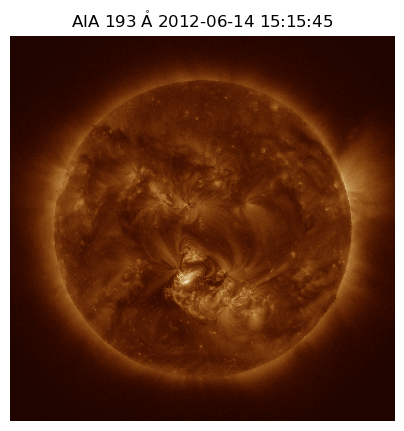

In [3]:
aia = m.Map(file[0])

fig=plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection=aia)
aia.cmap.set_bad('black')
aia.plot(axes=ax, annotate=True,clip_interval=[0,100]*u.percent)
plt.axis('off')

(-0.5, 4097.5, -0.5, 4097.5)

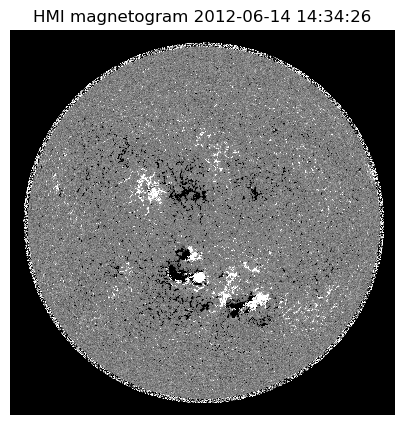

In [4]:
hmi = m.Map(file[1])
hmi_rot = hmi.rotate()
hmi_rot.plot_settings['norm'] = plt.Normalize(-50, 50)

fig=plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection=hmi_rot)
hmi_rot.cmap.set_bad('black')
hmi_rot.plot(axes=ax, annotate=True)
plt.axis('off')

### Cotemporally and cospatially aligning AIA map with HMI map
#### AIA resolution: 0.6 au per pixel; HMI resolution: 0.5 au per pixel

In [5]:
zoom_factor_x = (aia.meta['cdelt1']/hmi.meta['cdelt1'])
zoom_factor_y = (aia.meta['cdelt2']/hmi.meta['cdelt2'])
expanded_image = zoom(aia.data, (zoom_factor_y, zoom_factor_x), order=3)
new_aia = m.Map(expanded_image, aia.meta)

"""The chosen HMI and AIA files are the closest files according to time of observation. 
However they are not cotemporal. Hence we adjust the roation of the Sun such that the two files are cotemporally aligned."""
aia_out_time = new_aia.date + (hmi_rot.date - new_aia.date)  

""" A helioprojective frame on which we want to build our new rotated map """
out_frame = Helioprojective(observer='earth', obstime = aia_out_time,  rsun = new_aia.coordinate_frame.rsun)      


out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame = out_frame)  
header = m.make_fitswcs_header(new_aia.data.shape, out_center, scale=u.Quantity(new_aia.scale))
out_wcs = WCS(header)

In [6]:
""" reproject_to() only takes care of mapping one map into the World Coordinate System of another map. 
propagate_with_solar_wurface takes into account the differential rotation of the Sun while making the coordinate change."""

with propagate_with_solar_surface():
    out_warp = aia.reproject_to(out_wcs)

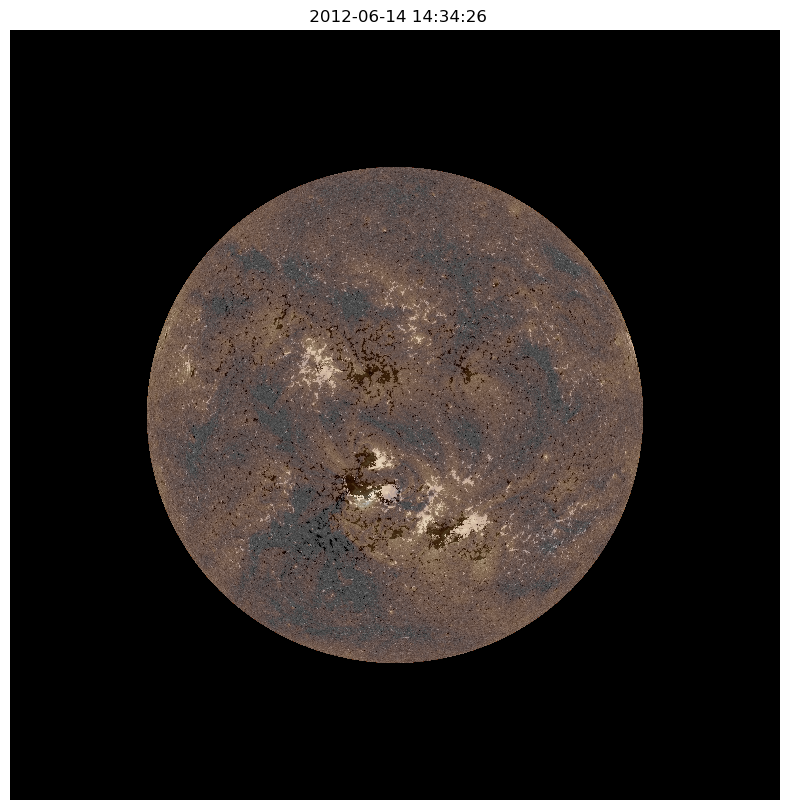

In [7]:
fig = plt.figure(figsize=[10,10])

ax = fig.add_subplot(projection=out_warp)
out_warp.plot(axes=ax, clip_interval=(5, 100)*u.percent)
hmi_rot.plot(axes=ax, annotate=False, autoalign=True, alpha=0.6)
plt.axis('off')

plt.show()